# 008. Test a linear model

source: python/ml-01-test-linear.ipynb

Here, we highlight the first simple test, using a linear model to predict river discharge.

In [4]:
import link_src

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=True) #n_workers=10, threads_per_worker=1, 
client = Client(cluster)  # memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [2]:
client

Client Scheduler: tcp://127.0.0.1:40078 Dashboard: http://127.0.0.1:43924/status,Cluster Workers: 8 Cores: 32 Memory: 203.20 GB


In [3]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


In [8]:
from python.aux.ml_flood_config import path_to_data
from python.aux.utils import open_data
# define some vars
data_path = f'{path_to_data}danube/'
print(data_path)

/home/srvx11/lehre/users/a1303583/ipython/ml_flood/data/danube/


In [5]:
from python.aux.utils import shift_time

In [ ]:
# load data
era5 = open_data(data_path, kw='era5')
glofas = open_data(data_path, kw='glofas_ra')

In [10]:
glofas = shift_time(glofas, -dt.timedelta(days=1))

In [11]:
era5.coords

Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float32 7.0 7.25 7.5 7.75 ... 19.25 19.5 19.75 20.0
  * level      (level) float64 850.0 700.0 500.0

In [12]:
glofas.coords

Coordinates:
  * longitude  (longitude) float64 7.05 7.15 7.25 7.35 ... 19.75 19.85 19.95
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2018-12-31

## feature selection

For the first test, we use large-scale precipitation, convective precipitation, relative topography, and averaged specific humidity (over all three levels).

In [13]:
if not 'lsp' in era5:
    lsp = era5['tp']-era5['cp']
    lsp.name = 'lsp'
else:
    lsp = era5['lsp']

reltop = era5['z'].sel(level=500) - era5['z'].sel(level=850)
reltop.name = 'reltop'

q_mean = era5['q'].mean('level')
q_mean.name = 'q_mean'

era5_features = xr.merge([era5['cp'], lsp, reltop, q_mean])

In [14]:
era5_features

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 53, time: 13545)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float32 7.0 7.25 7.5 7.75 ... 19.25 19.5 19.75 20.0
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>
    lsp        (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>
    reltop     (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>
    q_mean     (time, latitude, longitude) float32 dask.array<shape=(13545, 13, 53), chunksize=(13545, 13, 53)>

Interpolate era5 data onto glofas grid

In [20]:
era5_features = era5_features.interp(latitude=glofas.latitude,
                                     longitude=glofas.longitude)

Subset time

In [21]:
era5_features = era5_features.isel(time=slice(0*365,3*365))
glofas = glofas.isel(time=slice(0*365,3*365))

if len(era5_features.time) < 3000:
    era5_features = era5_features.load()
    glofas = glofas.load()

Inspect variables

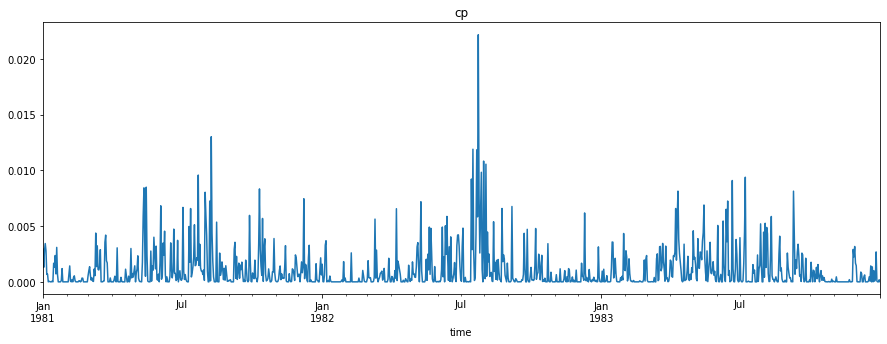

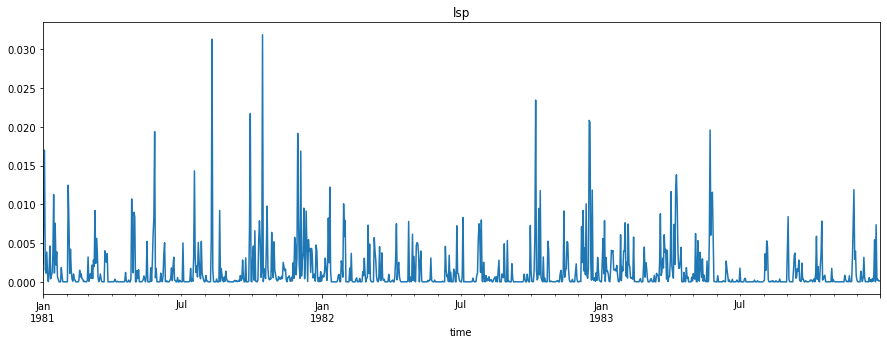

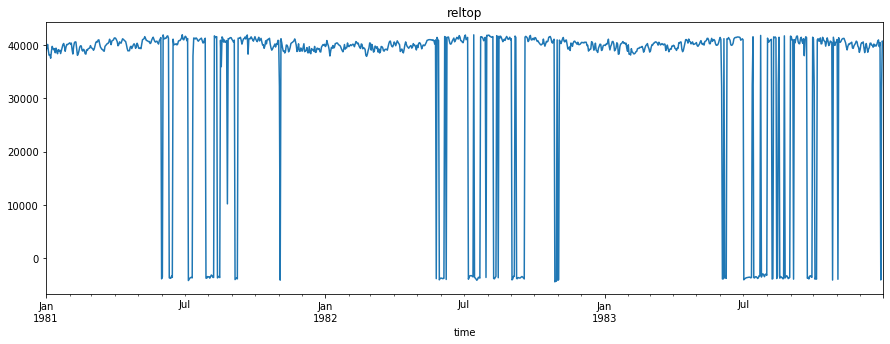

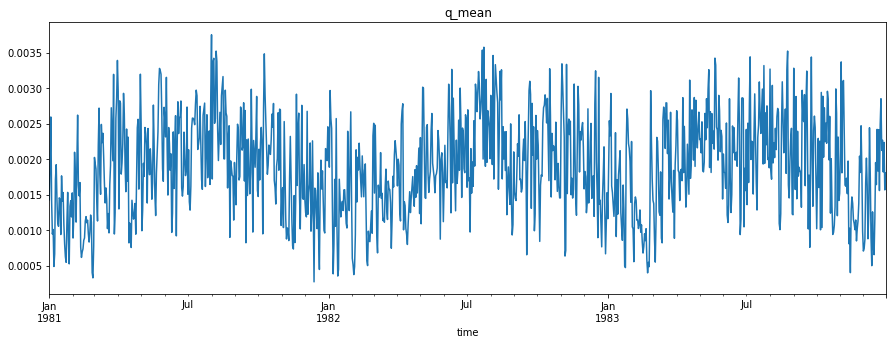

In [22]:
for var in era5_features:
    fig, ax = plt.subplots(figsize=(15,5))
    era5_features[var].isel(latitude=5, longitude=33).to_pandas().plot(ax=ax, title=var)

## daily change in discharge 
As discharge itself has a large memory component (high autocorrelation, dependence on previous values), we can also look on the changes in discharge through time.

In [24]:
krems = dict(latitude=48.403, longitude=15.615)

local_region = dict(latitude=slice(krems['latitude']+1.5, 
                                   krems['latitude']-1.5),
                   longitude=slice(krems['longitude']-1.5, 
                                   krems['longitude']+1.5))

In [40]:
# select area of interest and average over space for all features
dis = glofas.interp(krems)
y = dis
X = era5_features.sel(surrounding).mean(['latitude', 'longitude'])
print(X)

<xarray.Dataset>
Dimensions:  (time: 1095)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    cp       (time) float64 0.001624 0.0008551 0.0008235 ... 0.0004743 6.423e-05
    lsp      (time) float64 0.000967 0.002493 0.0079 ... 0.0001274 0.001093
    reltop   (time) float64 3.924e+04 3.87e+04 4.008e+04 ... 4.065e+04 4.001e+04
    q_mean   (time) float64 0.001418 0.001336 0.002463 ... 0.001842 0.001696


Add time shifted features as additional predictors (i.e. x(t-1), x(t-2), and so on):

In [29]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all':
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [33]:
shifts = range(1,11)
notshift_vars = ['swvl1', 'swvl2']
shift_vars = [v for v in X.data_vars if not v in notshift_vars]

Xs = add_shifted_predictors(X, shifts, variables=shift_vars)

In [34]:
Xs

<xarray.Dataset>
Dimensions:    (time: 1095)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
Data variables:
    cp         (time) float64 0.001624 0.0008551 ... 0.0004743 6.423e-05
    lsp        (time) float64 0.000967 0.002493 0.0079 ... 0.0001274 0.001093
    reltop     (time) float64 3.924e+04 3.87e+04 ... 4.065e+04 4.001e+04
    q_mean     (time) float64 0.001418 0.001336 0.002463 ... 0.001842 0.001696
    cp-1       (time) float64 nan 0.001624 0.0008551 ... 1.161e-06 0.0004743
    cp-2       (time) float64 nan nan 0.001624 ... 0.0003974 0.0001108 1.161e-06
    cp-3       (time) float64 nan nan nan ... 0.0008407 0.0003974 0.0001108
    cp-4       (time) float64 nan nan nan nan ... 4.177e-10 0.0008407 0.0003974
    cp-5       (time) float64 nan nan nan nan ... 0.0002298 4.177e-10 0.0008407
    cp-6       (time) float64 nan nan nan nan ... 0.0001662 0.0002298 4.177e-10
    cp-7       (time) float64 nan nan nan nan ... 0.0001152 0.0001662 0.000

In [43]:
Xar = Xs.to_array(dim='features')
yar = y.to_array()

# singleton dimension has to have the same name like in X
# so we set it to 'features' too
yar = yar.rename({'variable': 'features'})

# it confuses the concat if one has latitude but the other not
yar = yar.drop(['latitude', 'longitude'])

In [45]:
Xar

<xarray.DataArray (features: 44, time: 1095)>
array([[1.623629e-03, 8.551281e-04, 8.234900e-04, ..., 1.161331e-06,
        4.743362e-04, 6.423270e-05],
       [9.669637e-04, 2.492533e-03, 7.900144e-03, ..., 1.345064e-04,
        1.273530e-04, 1.092872e-03],
       [3.923759e+04, 3.869767e+04, 4.007942e+04, ..., 3.976337e+04,
        4.065292e+04, 4.001194e+04],
       ...,
       [         nan,          nan,          nan, ..., 1.904261e-03,
        2.624561e-03, 2.173802e-03],
       [         nan,          nan,          nan, ..., 2.641860e-03,
        1.904261e-03, 2.624561e-03],
       [         nan,          nan,          nan, ..., 2.316547e-03,
        2.641860e-03, 1.904261e-03]])
Coordinates:
  * time      (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
  * features  (features) <U9 'cp' 'lsp' 'reltop' ... 'q_mean-9' 'q_mean-10'

In [46]:
yar

<xarray.DataArray (features: 1, time: 1095)>
array([[517.917556, 513.782622, 520.214646, ..., 401.646237, 401.443795,
        394.493423]])
Coordinates:
  * time      (time) datetime64[ns] 1981-01-02 1981-01-03 ... 1984-01-01
  * features  (features) <U3 'dis'
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.4
    history:      Thu Jun 13 19:25:04 2019: cdo mergetime /home/srvx11/lehre/...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

## concat
- allows us to synchronize times and 
- get rid of nan entries with dropna()

In [48]:
Xy = xr.concat([Xar, yar], dim='features')  

# drop them as we cannot train on nan values
Xyt = Xy.dropna('time', how='any')

In [51]:
print(f"all data: \t {Xy.shape}")
print(f"without nans: \t {Xyt.shape}")

all data: 	 (45, 1096)
without nans: 	 (45, 1085)


In [52]:
predictand = 'dis'
predictors = [v for v in Xyt.coords['features'].values if v != predictand]

In [54]:
predictors

['cp',
 'lsp',
 'reltop',
 'q_mean',
 'cp-1',
 'cp-2',
 'cp-3',
 'cp-4',
 'cp-5',
 'cp-6',
 'cp-7',
 'cp-8',
 'cp-9',
 'cp-10',
 'lsp-1',
 'lsp-2',
 'lsp-3',
 'lsp-4',
 'lsp-5',
 'lsp-6',
 'lsp-7',
 'lsp-8',
 'lsp-9',
 'lsp-10',
 'reltop-1',
 'reltop-2',
 'reltop-3',
 'reltop-4',
 'reltop-5',
 'reltop-6',
 'reltop-7',
 'reltop-8',
 'reltop-9',
 'reltop-10',
 'q_mean-1',
 'q_mean-2',
 'q_mean-3',
 'q_mean-4',
 'q_mean-5',
 'q_mean-6',
 'q_mean-7',
 'q_mean-8',
 'q_mean-9',
 'q_mean-10']

In [55]:
print(Xyt)
Xda = Xyt.loc[predictors]
yda = Xyt.loc[predictand]

<xarray.DataArray (features: 45, time: 1085)>
array([[1.395622e-05, 0.000000e+00, 7.585690e-05, ..., 1.161331e-06,
        4.743362e-04, 6.423270e-05],
       [6.169035e-04, 1.099495e-04, 6.894520e-04, ..., 1.345064e-04,
        1.273530e-04, 1.092872e-03],
       [3.911006e+04, 3.913603e+04, 3.911511e+04, ..., 3.976337e+04,
        4.065292e+04, 4.001194e+04],
       ...,
       [1.335756e-03, 2.463035e-03, 1.488710e-03, ..., 2.641860e-03,
        1.904261e-03, 2.624561e-03],
       [1.418231e-03, 1.335756e-03, 2.463035e-03, ..., 2.316547e-03,
        2.641860e-03, 1.904261e-03],
       [5.138254e+02, 5.111764e+02, 5.085382e+02, ..., 3.928429e+02,
        4.016462e+02, 4.014438e+02]])
Coordinates:
  * time      (time) datetime64[ns] 1981-01-11 1981-01-12 ... 1983-12-31
  * features  (features) object 'cp' 'lsp' 'reltop' ... 'q_mean-10' 'dis'


In [56]:
time = yda.time
Xda = Xda.chunk(dict(time=-1, features=-1)).data.T
yda = yda.data.squeeze()

In [57]:
print(Xda)
print(yda)

dask.array<transpose, shape=(1085, 44), dtype=float64, chunksize=(1085, 44)>
[513.8254262  511.176361   508.53819285 ... 392.84289127 401.64623683
 401.4437952 ]


In [61]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression

In [62]:
model_kws = dict(n_jobs=-1, max_iter=10000, verbose=True)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', LinearRegression(**model_kws)),],
                verbose=True)

In [63]:
pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LinearRegression(C=1.0, class_weight=None, dual=False,
                                  fit_intercept=True, intercept_scaling=1.0,
                                  max_iter=10000, multi_class='ovr', n_jobs=-1,
                                  penalty='l2', random_state=None,
                                  solver='admm', solver_kwargs=None, tol=0.0001,
                                  verbose=True, warm_start=False))],
         verbose=True)

In [64]:
Xda = Xda.persist()

with ProgressBar():
    pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s


### In sample test for absolute discharge values

In [65]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [66]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [67]:
ytest = add_time(ytest, time, name='dis-forecast')
# initial state + changes = timeseries of forecasted discharge
ytest += yda[0]

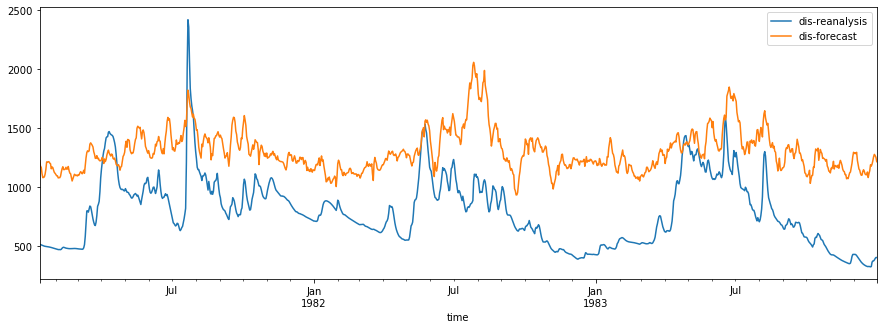

In [71]:
fig, ax = plt.subplots(figsize=(15,5))
Xyt.loc[predictand].to_pandas().plot(ax=ax, label='dis-reanalysis')
ytest.to_pandas().plot(ax=ax, label='dis-forecast')
plt.legend()

In [69]:
def recurrent_predict(pipe, X, n=1):
    """
    
    X : np.array or dask.array
        dimensions: (n, #features)
    n : int
        number of iterations
    """
    y = np.zeros(n)
    for i in range(n):
        y[i] = pipe.predict(X[np.newaxis, i])
    return y

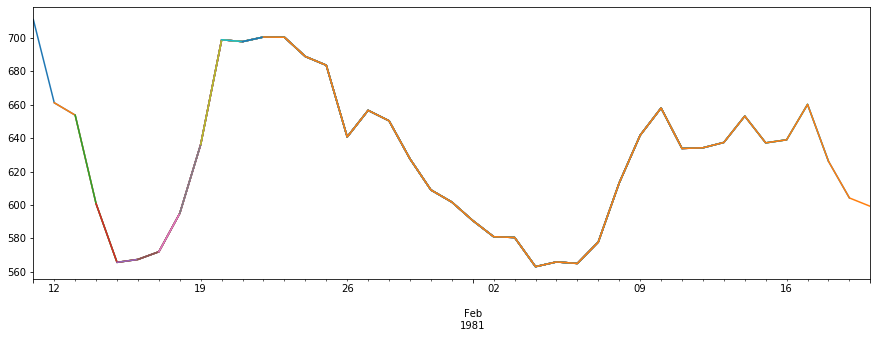

In [70]:
fig, ax = plt.subplots(figsize=(15,5))
t = 0
for t in range(12):
    y = pipe.predict(Xda[t:t+30])
    ydf = pd.Series(index=time.to_pandas().iloc[t:t+30], data=y)
    ydf.plot(ax=ax)